In [23]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
from datetime import datetime, timedelta


In [15]:
wind_table = Table.read('wind_data.ecsv').to_pandas()
shake_table = Table.read('wind_shake.ecsv').to_pandas()
exposure_table = Table.read('exposure_data.ecsv').to_pandas()
constraints_table = Table.read('wind_constraints.csv').to_pandas()

In [16]:
constraints_table

,col0,obsday,time_recorded,elrange,azrange
0,0,20210514,2021-05-14 09:00:00Z,"[0.0, 90.0]","[-180.0, 180.0]"
1,1,20210515,2021-05-15 20:15:34Z,"[0.0, 90.0]","[-180.0, 180.0]"
2,3,20210515,2021-05-16 03:36:03Z,"[0.0, 90.0]","[-90.0, 90.0]"
3,2,20210515,2021-05-16 04:28:50Z,"[0.0, 90.0]","[-180.0, 180.0]"
4,4,20210516,2021-05-16 20:17:16Z,"[0.0, 90.0]","[-180.0, 180.0]"
...,...,...,...,...,...
928,924,20241212,2024-12-13 06:31:05Z,"[0.0, 90.0]","[-180.0, 180.0]"
929,929,20241214,2024-12-14 18:10:42Z,"[0.0, 90.0]","[-180.0, 180.0]"
930,931,20241214,2024-12-15 02:39:10Z,"[0.0, 90.0]","[-179.0, -1.0]"
931,930,20241214,2024-12-15 06:32:19Z,"[0.0, 90.0]","[-180.0, 180.0]"


In [17]:
def analyze_constraints(df, constraint_column='azrange', default_constraint='[-180.0, 180.0]'):
    """
    Analyzes the number of times that constraints different from the default were applied.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the constraint data
    constraint_column (str): Name of the column containing constraint values
    default_constraint (str): The default constraint value to exclude from counting
    
    Returns:
    dict: A dictionary with constraint values as keys and their counts as values
    """
    # Count all constraints that are different from the default
    non_default_constraints = df[df[constraint_column] != default_constraint]
    
    # Get the count of each unique non-default constraint
    constraint_counts = non_default_constraints[constraint_column].value_counts().to_dict()
    
    # Get the total count of non-default constraints
    total_non_default = len(non_default_constraints)
    
    # Add the total to the dictionary
    result = {
        "total_non_default_constraints": total_non_default,
        "constraint_counts": constraint_counts
    }
    
    return result

results = analyze_constraints(constraints_table)
print(f"Total non-default constraints: {results['total_non_default_constraints']}")
print(f"Total default constraints: {len(constraints_table)-results['total_non_default_constraints']}")

print("Breakdown by constraint value:")
for constraint, count in results["constraint_counts"].items():
     print(f"  {constraint}: {count}")

Total non-default constraints: 400
Total default constraints: 533
Breakdown by constraint value:
  [-90.0, 90.0]: 79
  [-135.0, 135.0]: 12
  [-150.0, 90.0]: 12
  [0.0, 180.0]: 12
  [-180.0, 90.0]: 9
  [-135.0, 75.0]: 9
  [-120.0, 120.0]: 8
  [-90.0, 0.0]: 6
  [-135.0, 45.0]: 5
  [180.0, 360.0]: 5
  [-179.0, -1.0]: 5
  [-45.0, 135.0]: 5
  [90.0, 270.0]: 5
  [-170.0, 0.0]: 5
  [-120.0, 90.0]: 5
  [180.0, 359.0]: 4
  [-85.0, 85.0]: 4
  [-95.0, 115.0]: 4
  [-110.0, 70.0]: 4
  [-105.0, 105.0]: 4
  [-120.0, 60.0]: 4
  [-45.0, 90.0]: 4
  [90.0, -90.0]: 3
  [181.0, 359.0]: 3
  [-240.0, 0.0]: 3
  [-150.0, 60.0]: 3
  [-75.0, 165.0]: 3
  [-100.0, 100.0]: 3
  [-100.0, 160.0]: 3
  [-110.0, 110.0]: 3
  [-85.0, 125.0]: 2
  [-110.0, 0.0]: 2
  [38.0, 48.0]: 2
  [-60.0, 120.0]: 2
  [-90.0, -90.0]: 2
  [100.0, 360.0]: 2
  [-180.0, 45.0]: 2
  [-225.0, 45.0]: 2
  [-150.0, 50.0]: 2
  [-185.0, 55.0]: 2
  [180.0, -1.0]: 2
  [0.0, 90.0]: 2
  [-140.0, 100.0]: 2
  [-125.0, 145.0]: 2
  [200.0, 90.0]: 2
  [-110.0,

In [18]:
def analyze_cardinal_access(df, constraint_column='azrange'):
    """
    Analyzes accessibility of cardinal directions (N, E, S, W) based on azimuth constraints.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the constraint data
    constraint_column (str): Name of the column containing constraint values
    
    Returns:
    dict: Analysis of cardinal direction accessibility
    """
    # Initialize counters for each cardinal direction
    cardinal_access = {
        "north": 0,  # 0 degrees
        "east": 0,   # 90 degrees
        "south": 0,  # 180/-180 degrees
        "west": 0    # 270/-90 degrees
    }
    
    # Track detailed access for each constraint type
    constraint_details = {}
    
    # Function to check if an angle is within a constraint range
    def is_in_range(angle, min_val, max_val):
        # Normalize angle to [-180, 180]
        while angle > 180:
            angle -= 360
        while angle < -180:
            angle += 360
            
        # Check if angle is within range
        if min_val <= max_val:
            return min_val <= angle <= max_val
        else:
            # Handle ranges that cross the -180/180 boundary
            return angle >= min_val or angle <= max_val
    
    # Process each row in the DataFrame
    for _, row in df.iterrows():
        constraint_str = row[constraint_column]
        
        # Skip if constraint is missing or invalid
        if not isinstance(constraint_str, str):
            continue
        
        try:
            # Parse the constraint string to get min and max values
            constraint_str_clean = constraint_str.strip('[]')
            min_val, max_val = map(float, constraint_str_clean.split(','))
            
            # Check cardinal directions
            north_accessible = is_in_range(0, min_val, max_val)
            east_accessible = is_in_range(90, min_val, max_val)
            south_accessible = is_in_range(180, min_val, max_val) or is_in_range(-180, min_val, max_val)
            west_accessible = is_in_range(-90, min_val, max_val) or is_in_range(270, min_val, max_val)
            
            # Update totals for each direction
            if north_accessible:
                cardinal_access["north"] += 1
            if east_accessible:
                cardinal_access["east"] += 1
            if south_accessible:
                cardinal_access["south"] += 1
            if west_accessible:
                cardinal_access["west"] += 1
            
            # Store constraint details if not already present
            if constraint_str not in constraint_details:
                constraint_details[constraint_str] = {
                    "range": [min_val, max_val],
                    "north": north_accessible,
                    "east": east_accessible,
                    "south": south_accessible,
                    "west": west_accessible,
                    "count": 1
                }
            else:
                constraint_details[constraint_str]["count"] += 1
                
        except Exception as e:
            print(f"Error parsing constraint: {constraint_str}. Error: {e}")
    
    # Calculate percentages
    total_observations = len(df)
    cardinal_access_percent = {
        direction: (count / total_observations) * 100 
        for direction, count in cardinal_access.items()
    }
    
    # Compile results
    result = {
        "total_observations": total_observations,
        "cardinal_access": cardinal_access,
        "cardinal_access_percent": cardinal_access_percent,
        "constraint_details": constraint_details
    }
    
    return result

In [19]:
def print_cardinal_analysis(results):
    """
    Prints the results from the analyze_cardinal_access function in a readable format,
    with constraint details sorted by count in descending order.
    
    Parameters:
    results (dict): The results dictionary returned by analyze_cardinal_access
    """
    print("\n=== CARDINAL DIRECTION ANALYSIS ===")
    print(f"Total observations analyzed: {results['total_observations']}")
    
    print("\n--- CARDINAL DIRECTION ACCESSIBILITY ---")
    print("Direction | Count | Percentage")
    print("-" * 35)
    for direction, count in results['cardinal_access'].items():
        percentage = results['cardinal_access_percent'][direction]
        print(f"{direction.title():9} | {count:5d} | {percentage:6.1f}%")
    
    print("\n--- CONSTRAINT DETAILS ---")
    print("Constraint Range | Count | North | East | South | West")
    print("-" * 60)
    
    # Sort constraints by count in descending order
    sorted_constraints = sorted(
        results['constraint_details'].items(),
        key=lambda x: x[1]['count'],
        reverse=True
    )
    
    for constraint, details in sorted_constraints:
        range_str = constraint
        count = details['count']
        n = "Yes" if details['north'] else "No "
        e = "Yes" if details['east'] else "No "
        s = "Yes" if details['south'] else "No "
        w = "Yes" if details['west'] else "No "
        print(f"{range_str:15} | {count:5d} | {n:5} | {e:5} | {s:5} | {w:5}")


In [20]:
constraints_table = Table.read('wind_constraints.csv').to_pandas()

# Run the analysis
results_cardinal = analyze_cardinal_access(constraints_table)

# Print the results
print_cardinal_analysis(results_cardinal)


=== CARDINAL DIRECTION ANALYSIS ===
Total observations analyzed: 933

--- CARDINAL DIRECTION ACCESSIBILITY ---
Direction | Count | Percentage
-----------------------------------
North     |   860 |   92.2%
East      |   780 |   83.6%
South     |   642 |   68.8%
West      |   815 |   87.4%

--- CONSTRAINT DETAILS ---
Constraint Range | Count | North | East | South | West
------------------------------------------------------------
[-180.0, 180.0] |   533 | Yes   | Yes   | Yes   | Yes  
[-90.0, 90.0]   |    79 | Yes   | Yes   | No    | Yes  
[-135.0, 135.0] |    12 | Yes   | Yes   | No    | Yes  
[0.0, 180.0]    |    12 | Yes   | Yes   | Yes   | No   
[-150.0, 90.0]  |    12 | Yes   | Yes   | No    | Yes  
[-180.0, 90.0]  |     9 | Yes   | Yes   | Yes   | Yes  
[-135.0, 75.0]  |     9 | Yes   | No    | No    | Yes  
[-120.0, 120.0] |     8 | Yes   | Yes   | No    | Yes  
[-90.0, 0.0]    |     6 | Yes   | No    | No    | Yes  
[-45.0, 135.0]  |     5 | Yes   | Yes   | No    | No   
[180.

In [21]:

def compute_observation_constraints(df, obsday_column='obsday', time_column='time_recorded', 
                                  constraint_column='azrange', default_constraint='[-180.0, 180.0]'):
    """
    Computes the total observation time and constrained vs unconstrained times for each observation night.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the observation data
    obsday_column (str): Name of the column containing observation day identifiers
    time_column (str): Name of the column containing timestamps
    constraint_column (str): Name of the column containing constraint values
    default_constraint (str): The default constraint value representing unconstrained observation
    
    Returns:
    pd.DataFrame: DataFrame with obsday and corresponding time analysis
    """
    # Ensure the time column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df[time_column]):
        df = df.copy()
        df[time_column] = pd.to_datetime(df[time_column])
    
    # Initialize result container
    observation_stats = []
    
    # Group data by observation day
    grouped = df.groupby(obsday_column)
    
    for obsday, group in grouped:
        # Sort by timestamp to ensure correct order
        group = group.sort_values(by=time_column)
        
        # Get first and last timestamps
        start_time = group[time_column].iloc[0]
        end_time = group[time_column].iloc[-1]
        
        # Calculate total duration in hours
        total_duration_hours = (end_time - start_time).total_seconds() / 3600
        
        # Count records with default (unconstrained) vs non-default (constrained) values
        unconstrained_records = group[group[constraint_column] == default_constraint]
        constrained_records = group[group[constraint_column] != default_constraint]
        
        # If we have at least two timestamped records, we can estimate durations
        if len(group) >= 2:
            # Calculate time spans
            constrained_time_hours = 0
            unconstrained_time_hours = 0
            
            # Convert timestamps to list for easier processing
            timestamps = group[time_column].tolist()
            constraints = group[constraint_column].tolist()
            
            # Process time intervals between consecutive measurements
            for i in range(len(timestamps) - 1):
                interval_hours = (timestamps[i+1] - timestamps[i]).total_seconds() / 3600
                
                # Decide whether to attribute this interval to constrained or unconstrained
                # We'll attribute based on the constraint at the beginning of the interval
                if constraints[i] == default_constraint:
                    unconstrained_time_hours += interval_hours
                else:
                    constrained_time_hours += interval_hours
        else:
            # Not enough data points to estimate durations
            constrained_time_hours = 0 if len(constrained_records) == 0 else total_duration_hours
            unconstrained_time_hours = 0 if len(unconstrained_records) == 0 else total_duration_hours
        
        # Add to results
        observation_stats.append({
            'obsday': obsday,
            'start_time': start_time,
            'end_time': end_time,
            'total_duration_hours': total_duration_hours,
            'constrained_time_hours': constrained_time_hours,
            'unconstrained_time_hours': unconstrained_time_hours,
            'constrained_percentage': (constrained_time_hours / total_duration_hours * 100) if total_duration_hours > 0 else 0,
            'unconstrained_percentage': (unconstrained_time_hours / total_duration_hours * 100) if total_duration_hours > 0 else 0,
            'constrained_records': len(constrained_records),
            'unconstrained_records': len(unconstrained_records),
            'total_records': len(group)
        })
    
    # Convert to DataFrame
    result_df = pd.DataFrame(observation_stats)
    result_df = result_df.sort_values(by='obsday')
    
    return result_df



def print_constraint_time_analysis(results_df):
    """
    Prints a summary of the constraint time analysis in a readable format.
    
    Parameters:
    results_df (pd.DataFrame): The DataFrame returned by compute_observation_constraints
    """
    print("\n=== OBSERVATION TIME ANALYSIS ===")
    print(f"Total observation nights analyzed: {len(results_df)}")
    
    # Calculate overall totals
    total_hours = results_df['total_duration_hours'].sum()
    constrained_hours = results_df['constrained_time_hours'].sum()
    unconstrained_hours = results_df['unconstrained_time_hours'].sum()
    
    print(f"\nTotal observation time: {total_hours:.2f} hours")
    print(f"Total constrained time: {constrained_hours:.2f} hours ({constrained_hours/total_hours*100:.1f}%)")
    print(f"Total unconstrained time: {unconstrained_hours:.2f} hours ({unconstrained_hours/total_hours*100:.1f}%)")
    
    print("\n--- OBSERVATION DETAILS BY NIGHT ---")
    print("ObsDay | Duration (h) | Constrained (h) | Constrained (%) | Unconstrained (h) | Unconstrained (%)")
    print("-" * 100)
    
    for _, row in results_df.iterrows():
        obsday = row['obsday']
        total = row['total_duration_hours']
        constr = row['constrained_time_hours']
        unconstr = row['unconstrained_time_hours']
        constr_pct = row['constrained_percentage']
        unconstr_pct = row['unconstrained_percentage']
        
        print(f"{obsday:6} | {total:12.2f} | {constr:14.2f} | {constr_pct:14.1f} | {unconstr:16.2f} | {unconstr_pct:16.1f}")


In [22]:
observation_analysis = compute_observation_constraints(constraints_table)
print_constraint_time_analysis(observation_analysis)


=== OBSERVATION TIME ANALYSIS ===
Total observation nights analyzed: 216

Total observation time: 2723.35 hours
Total constrained time: 335.44 hours (12.3%)
Total unconstrained time: 2387.92 hours (87.7%)

--- OBSERVATION DETAILS BY NIGHT ---
ObsDay | Duration (h) | Constrained (h) | Constrained (%) | Unconstrained (h) | Unconstrained (%)
----------------------------------------------------------------------------------------------------
20210514 |         0.00 |           0.00 |            0.0 |             0.00 |              0.0
20210515 |         8.22 |           0.88 |           10.7 |             7.34 |             89.3
20210516 |         8.17 |           1.31 |           16.1 |             6.85 |             83.9
20210519 |         9.63 |           0.48 |            5.0 |             9.15 |             95.0
20210521 |        14.85 |           2.91 |           19.6 |            11.94 |             80.4
20210606 |         7.76 |           0.30 |            3.8 |             7.47 

In [46]:
observation_analysis[-20:]

,obsday,start_time,end_time,total_duration_hours,constrained_time_hours,unconstrained_time_hours,constrained_percentage,unconstrained_percentage,constrained_records,unconstrained_records,total_records
196,20240914,2024-09-14 19:17:36+00:00,2024-09-15 08:13:17+00:00,12.928056,1.016111,11.911944,7.859737,92.140263,5,3,8
197,20240917,2024-09-17 19:13:30+00:00,2024-09-18 11:37:26+00:00,16.398889,0.190833,16.208056,1.163697,98.836303,2,2,4
198,20240919,2024-09-19 19:10:47+00:00,2024-09-20 08:53:03+00:00,13.704444,5.619722,8.084722,41.006567,58.993433,2,3,5
199,20240920,2024-09-20 19:09:26+00:00,2024-09-21 06:17:19+00:00,11.131389,0.638889,10.492500,5.739525,94.260475,1,3,4
200,20240921,2024-09-21 19:08:05+00:00,2024-09-22 08:44:36+00:00,13.608611,0.000000,13.608611,0.000000,100.000000,0,3,3
201,20241014,2024-10-14 18:37:54+00:00,2024-10-15 08:17:44+00:00,13.663889,0.051111,13.612778,0.374060,99.625940,2,2,4
202,20241015,2024-10-15 18:37:54+00:00,2024-10-16 09:50:39+00:00,15.212500,0.000000,15.212500,0.000000,100.000000,1,2,3
203,20241017,2024-10-17 18:35:41+00:00,2024-10-18 05:48:46+00:00,11.218056,1.874722,9.343333,16.711650,83.288350,3,3,6
204,20241027,2024-10-27 18:25:38+00:00,2024-10-28 07:04:58+00:00,12.655556,1.009167,11.646389,7.974100,92.025900,2,2,4
205,20241028,2024-10-28 18:24:44+00:00,2024-10-29 06:39:26+00:00,12.245000,2.219167,10.025833,18.123043,81.876957,3,2,5


In [43]:
def plot_constraint_hours_timeline(results_df, output_file=None, figsize=(8, 5)):
    """
    Plots constrained and unconstrained observation hours as a function of time
    using dots connected by lines.
    
    Parameters:
    results_df (pd.DataFrame): The DataFrame returned by compute_observation_constraints
    output_file (str, optional): Path to save the figure. If None, the plot is displayed but not saved.
    figsize (tuple): Figure size in inches (width, height)
    
    Returns:
    matplotlib.figure.Figure: The figure object containing the plot
    """
    # Convert obsday to datetime for x-axis if it's not already
    if not pd.api.types.is_datetime64_any_dtype(results_df['start_time']):
        raise ValueError("The 'start_time' column must be in datetime format")
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Sort by start_time to ensure chronological order
    df_sorted = results_df.sort_values(by='start_time')
    
    # Extract dates for x-axis - use the start time for each observation night
    dates = df_sorted['start_time']
    
    # Plot the lines with dots
    ax.plot(dates, df_sorted['total_duration_hours'], 's-', color='navy', 
            linewidth=4, markersize=6, label='Total Duration')
    
    ax.plot(dates, df_sorted['unconstrained_time_hours'], 'o-', color='green', 
            linewidth=2, markersize=6, label='Unconstrained')
    
    ax.plot(dates, df_sorted['constrained_time_hours'], '*-', color='orange', 
            linewidth=2, markersize=6, label='Constrained')
    
    # Configure the x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')
    
    # Add labels and title
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Observation Hours', fontsize=12)
    ax.set_title('Constrained vs. Unconstrained Observation Time', fontsize=14)
    
    # Set y-axis to start at 0
    ax.set_ylim(bottom=0)
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Add gridlines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cut-off labels
    #fig.tight_layout()
    
    # Save the figure if an output path is provided
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return

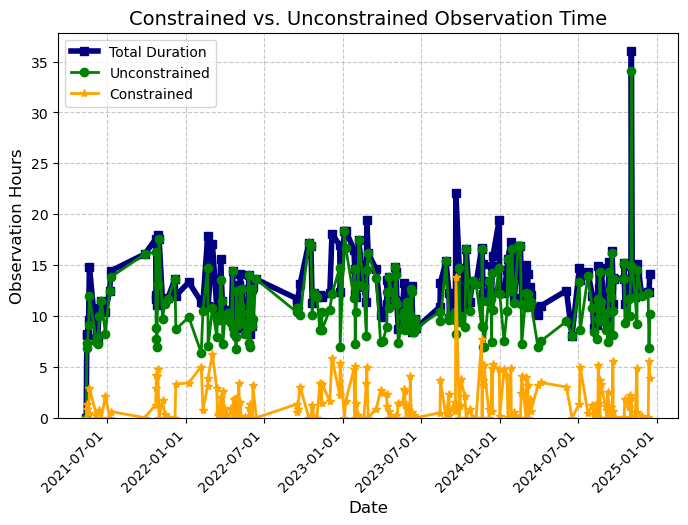

In [44]:
plot_constraint_hours_timeline(observation_analysis, output_file='constraint_timeline.jpg')

Initial Data Analysis:

Constraints Summary:
       azrange_width  is_restricted
count     933.000000     933.000000
mean      286.857449       0.424437
std        99.141130       0.494522
min         0.000000       0.000000
25%       180.000000       0.000000
50%       360.000000       0.000000
75%       360.000000       1.000000
max      1300.000000       1.000000

Number of restricted cases: 396

Time ranges of the data:

Constraints time range:
Start: 2021-05-14 09:00:00
End: 2024-12-15 08:17:18

Wind time range:
Start: 2019-03-27 03:08:42
End: 2024-10-24 22:32:49

Exposure time range:
Start: 2021-05-30 03:33:27.849600
End: 2024-11-01 12:40:32.073600

Found 471 matching records out of 933 constraints

Correlation with azrange_width:
azrange_width     1.000000
mount_el          0.003209
wind_direction   -0.035448
opening_angle    -0.035939
mount_az         -0.048630
gust             -0.105746
wind_speed       -0.186216
Name: azrange_width, dtype: float64

Summary Statistics by Restr

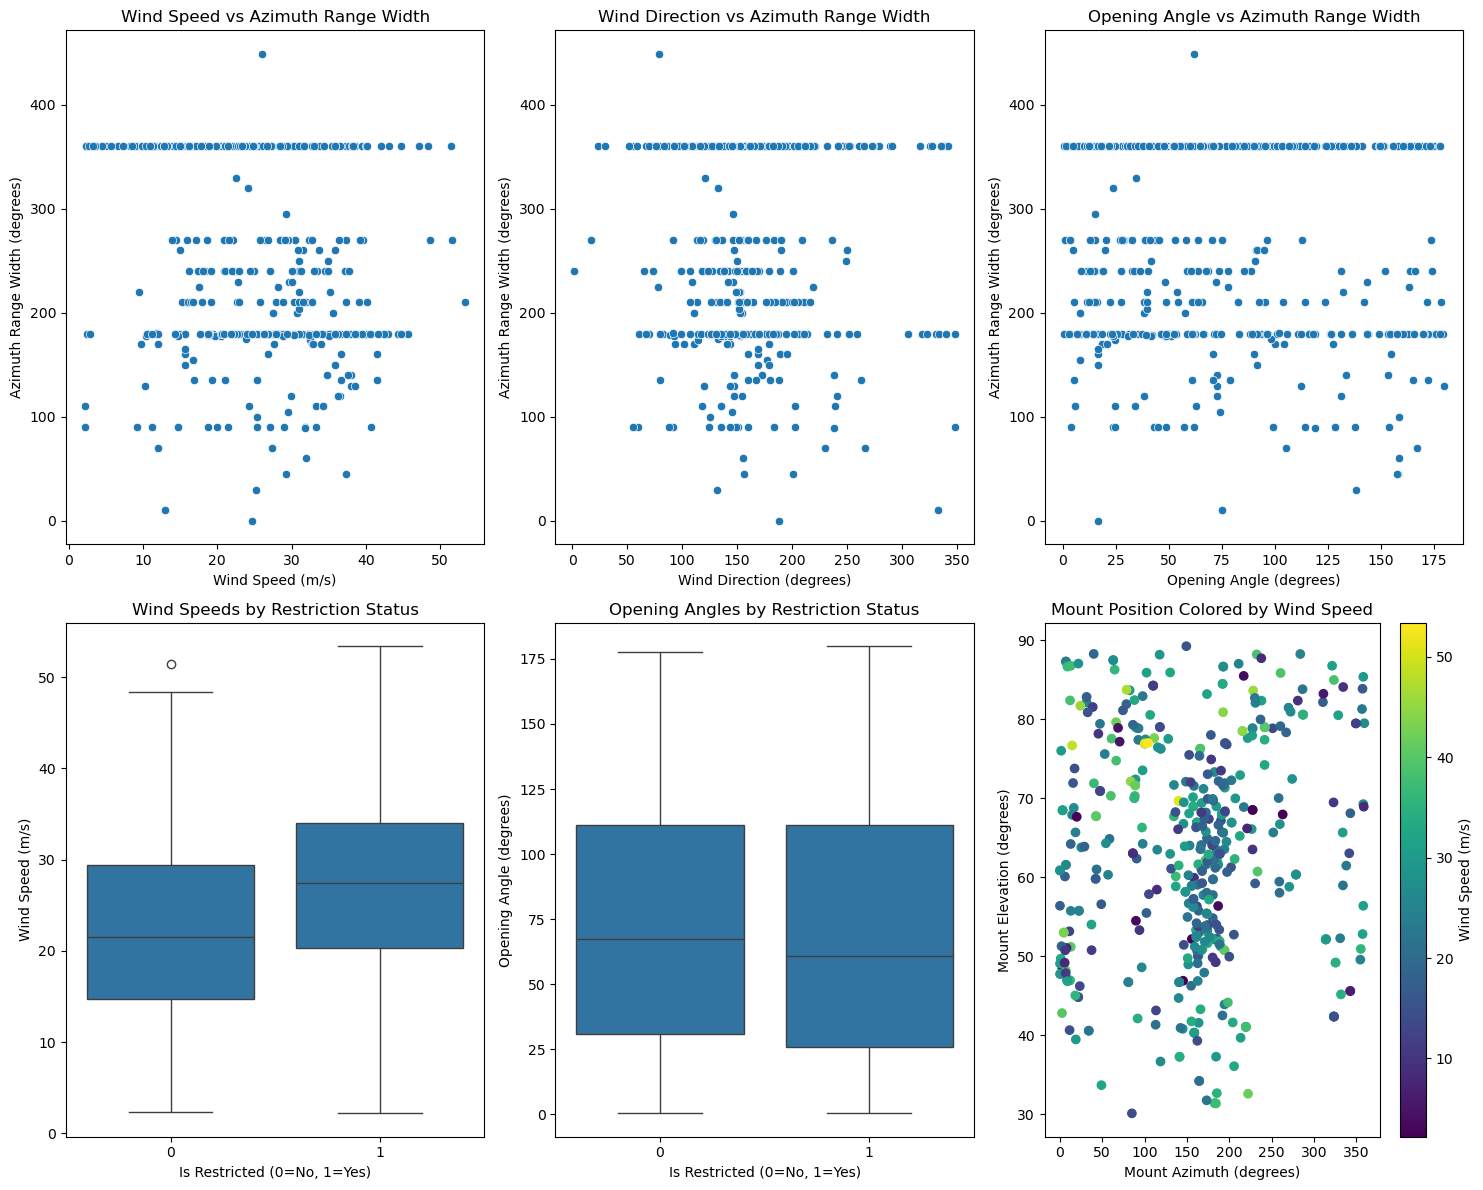


Wind Speed Analysis for Restricted Cases:

Wind speeds during restrictions:
count    272.000000
mean      27.066177
std        9.361972
min        2.200000
25%       20.375000
50%       27.500000
75%       34.000000
max       53.400002
Name: wind_speed, dtype: float64

Wind speeds during normal operation:
count    199.000000
mean      22.070852
std        9.963912
min        2.300000
25%       14.750000
50%       21.500000
75%       29.400000
max       51.500000
Name: wind_speed, dtype: float64

t-test results for wind speed difference:
t-statistic: 5.566
p-value: 0.000

Opening Angle Analysis by Restriction Status:

Restricted cases (is_restricted = 1):
Number of cases: 272

Opening Angle Statistics:
count    272.000000
mean      71.457102
std       52.529194
min        0.424652
25%       25.845134
50%       60.954359
75%      111.317632
max      179.864127
Name: opening_angle, dtype: float64

Most common opening angle ranges:
opening_angle
(0.245, 30.331]       79
(30.331, 60.238]  

/tmp/ipykernel_736436/1942328802.py:241: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  angle_analysis = merged_df.groupby('opening_angle_bin').agg({


In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast  # for safely evaluating string representation of lists

# Convert time columns to datetime and standardize timezones
constraints_table['time_recorded'] = pd.to_datetime(constraints_table['time_recorded']).dt.tz_localize(None)
wind_table['TIMESTAMP'] = pd.to_datetime(wind_table['TIMESTAMP']).dt.tz_localize(None)
exposure_table['TIMESTAMP'] = pd.to_datetime(exposure_table['TIMESTAMP']).dt.tz_localize(None)

# Function to safely parse azrange string and calculate width
def get_azrange_width(azrange_str):
    try:
        # Convert string representation of list to actual list
        azrange = ast.literal_eval(azrange_str)
        return abs(float(azrange[1]) - float(azrange[0]))
    except (ValueError, SyntaxError) as e:
        print(f"Error processing azrange: {azrange_str}")
        return None

# Calculate azrange_width and is_restricted for constraints table
constraints_table['azrange_width'] = constraints_table['azrange'].apply(get_azrange_width)
constraints_table['is_restricted'] = constraints_table['azrange_width'].apply(
    lambda x: 1 if x < 300 else 0
)

def calculate_angle_difference(angle1, angle2):
    """
    Calculate the absolute angular difference between two angles in degrees,
    considering the circular nature of angles (0-360 degrees).
    
    Parameters:
    -----------
    angle1, angle2 : float
        Angles in degrees
        
    Returns:
    --------
    float
        Absolute angular difference in degrees (0-180)
    """
    diff = abs(angle1 - angle2) % 360
    return min(diff, 360 - diff)

# Modified function to find closest measurements
def find_closest_measurements(target_time, measurements, time_col, window_minutes=30):
    window = pd.Timedelta(minutes=window_minutes)
    time_diffs = abs(measurements[time_col] - target_time)
    closest_idx = time_diffs.idxmin()
    
    if time_diffs[closest_idx] <= window:
        return measurements.loc[closest_idx]
    return None

# Create merged dataset with closest wind measurements
merged_data = []

for idx, constraint in constraints_table.iterrows():
    closest_wind = find_closest_measurements(
        constraint['time_recorded'], 
        wind_table, 
        'TIMESTAMP',
        window_minutes=120  # Increased window to 2 hours to find more matches
    )
    
    closest_exposure = find_closest_measurements(
        constraint['time_recorded'], 
        exposure_table, 
        'TIMESTAMP',
        window_minutes=120
    )
    
    if closest_wind is not None and closest_exposure is not None:
        merged_row = {
            'time_recorded': constraint['time_recorded'],
            'azrange_width': constraint['azrange_width'],
            'is_restricted': constraint['is_restricted'],
            'wind_speed': closest_wind['WIND_SPEED'],
            'wind_direction': closest_wind['WIND_DIRECTION'],
            'gust': closest_wind['GUST'],
            'mount_el': closest_exposure['MOUNT_EL'],
            'mount_az': closest_exposure['MOUNT_AZ'],
            'opening_angle': calculate_angle_difference(
                closest_wind['WIND_DIRECTION'],
                closest_exposure['MOUNT_AZ']
            )
        }
        merged_data.append(merged_row)

merged_df = pd.DataFrame(merged_data)

# Print time ranges and initial analysis
print("Initial Data Analysis:")
print("\nConstraints Summary:")
print(constraints_table[['azrange_width', 'is_restricted']].describe())
print("\nNumber of restricted cases:", constraints_table['is_restricted'].sum())

print("\nTime ranges of the data:")
print("\nConstraints time range:")
print("Start:", constraints_table['time_recorded'].min())
print("End:", constraints_table['time_recorded'].max())

print("\nWind time range:")
print("Start:", wind_table['TIMESTAMP'].min())
print("End:", wind_table['TIMESTAMP'].max())

print("\nExposure time range:")
print("Start:", exposure_table['TIMESTAMP'].min())
print("End:", exposure_table['TIMESTAMP'].max())

print(f"\nFound {len(merged_df)} matching records out of {len(constraints_table)} constraints")

if len(merged_df) > 0:
    # Calculate correlations
    correlations = merged_df[['azrange_width', 'wind_speed', 'wind_direction', 'gust', 
                             'mount_el', 'mount_az', 'opening_angle']].corr()

    print("\nCorrelation with azrange_width:")
    print(correlations['azrange_width'].sort_values(ascending=False))

    # Summary statistics by restriction status
    summary_stats = merged_df.groupby('is_restricted').agg({
        'wind_speed': ['mean', 'std', 'min', 'max'],
        'wind_direction': ['mean', 'std'],
        'gust': ['mean', 'std'],
        'mount_el': ['mean', 'std'],
        'mount_az': ['mean', 'std']
    }).round(2)

    print("\nSummary Statistics by Restriction Status:")
    print(summary_stats)

    # Create visualizations
    plt.figure(figsize=(15, 12))

    # Wind speed vs azrange width
    plt.subplot(2, 3, 1)
    sns.scatterplot(data=merged_df, x='wind_speed', y='azrange_width')
    plt.title('Wind Speed vs Azimuth Range Width')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Azimuth Range Width (degrees)')

    # Wind direction vs azrange width
    plt.subplot(2, 3, 2)
    sns.scatterplot(data=merged_df, x='wind_direction', y='azrange_width')
    plt.title('Wind Direction vs Azimuth Range Width')
    plt.xlabel('Wind Direction (degrees)')
    plt.ylabel('Azimuth Range Width (degrees)')

    # Opening angle vs azrange width
    plt.subplot(2, 3, 3)
    sns.scatterplot(data=merged_df, x='opening_angle', y='azrange_width')
    plt.title('Opening Angle vs Azimuth Range Width')
    plt.xlabel('Opening Angle (degrees)')
    plt.ylabel('Azimuth Range Width (degrees)')

    # Box plot of wind speeds by restriction status
    plt.subplot(2, 3, 4)
    sns.boxplot(data=merged_df, x='is_restricted', y='wind_speed')
    plt.title('Wind Speeds by Restriction Status')
    plt.xlabel('Is Restricted (0=No, 1=Yes)')
    plt.ylabel('Wind Speed (m/s)')

    # Box plot of opening angles by restriction status
    plt.subplot(2, 3, 5)
    sns.boxplot(data=merged_df, x='is_restricted', y='opening_angle')
    plt.title('Opening Angles by Restriction Status')
    plt.xlabel('Is Restricted (0=No, 1=Yes)')
    plt.ylabel('Opening Angle (degrees)')

    # Mount position scatter plot
    plt.subplot(2, 3, 6)
    scatter = plt.scatter(merged_df['mount_az'], merged_df['mount_el'], 
                         c=merged_df['wind_speed'], cmap='viridis')
    plt.colorbar(scatter, label='Wind Speed (m/s)')
    plt.title('Mount Position Colored by Wind Speed')
    plt.xlabel('Mount Azimuth (degrees)')
    plt.ylabel('Mount Elevation (degrees)')

    plt.tight_layout()
    plt.show()

    # Additional analysis focusing on wind speed
    print("\nWind Speed Analysis for Restricted Cases:")
    restricted_mask = merged_df['is_restricted'] == 1
    unrestricted_mask = merged_df['is_restricted'] == 0
    
    print("\nWind speeds during restrictions:")
    print(merged_df[restricted_mask]['wind_speed'].describe())
    
    print("\nWind speeds during normal operation:")
    print(merged_df[unrestricted_mask]['wind_speed'].describe())

    # Statistical test
    if len(merged_df[restricted_mask]) > 0 and len(merged_df[unrestricted_mask]) > 0:
        t_stat, p_value = stats.ttest_ind(
            merged_df[restricted_mask]['wind_speed'],
            merged_df[unrestricted_mask]['wind_speed']
        )
        print(f"\nt-test results for wind speed difference:")
        print(f"t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.3f}")
    print("\nOpening Angle Analysis by Restriction Status:")
    
    # Analysis for restricted cases
    restricted_data = merged_df[merged_df['is_restricted'] == 1]
    unrestricted_data = merged_df[merged_df['is_restricted'] == 0]
    
    print("\nRestricted cases (is_restricted = 1):")
    print("Number of cases:", len(restricted_data))
    print("\nOpening Angle Statistics:")
    print(restricted_data['opening_angle'].describe())
    print("\nMost common opening angle ranges:")
    print(pd.cut(restricted_data['opening_angle'], bins=6).value_counts().sort_index())
    
    print("\nUnrestricted cases (is_restricted = 0):")
    print("Number of cases:", len(unrestricted_data))
    print("\nOpening Angle Statistics:")
    print(unrestricted_data['opening_angle'].describe())
    print("\nMost common opening angle ranges:")
    print(pd.cut(unrestricted_data['opening_angle'], bins=6).value_counts().sort_index())
    
    # Statistical test for opening angle difference
    if len(restricted_data) > 0 and len(unrestricted_data) > 0:
        t_stat, p_value = stats.ttest_ind(
            restricted_data['opening_angle'],
            unrestricted_data['opening_angle']
        )
        print(f"\nt-test for opening angle difference between restricted and unrestricted cases:")
        print(f"t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.3f}")
    
    # Create detailed bins for opening angles and analyze restriction rates
    bins = [0, 30, 60, 90, 120, 150, 180]
    labels = ['0-30°', '30-60°', '60-90°', '90-120°', '120-150°', '150-180°']
    merged_df['opening_angle_bin'] = pd.cut(merged_df['opening_angle'], bins=bins, labels=labels)
    
    angle_analysis = merged_df.groupby('opening_angle_bin').agg({
        'is_restricted': ['count', 'mean'],
        'wind_speed': 'mean'
    }).round(3)
    
    angle_analysis.columns = ['total_cases', 'restriction_rate', 'avg_wind_speed']
    
    print("\nRestriction Analysis by Opening Angle Range:")
    print(angle_analysis)

else:
    print("No matching records found within the time window.")
    print("Time differences between tables (showing first few records):")
    
    for idx, constraint in constraints_table.head().iterrows():
        print(f"\nConstraint at {constraint['time_recorded']}:")
        closest_wind_time = abs(wind_table['TIMESTAMP'] - constraint['time_recorded']).min()
        closest_exp_time = abs(exposure_table['TIMESTAMP'] - constraint['time_recorded']).min()
        print(f"Closest wind measurement: {closest_wind_time}")
        print(f"Closest exposure measurement: {closest_exp_time}")

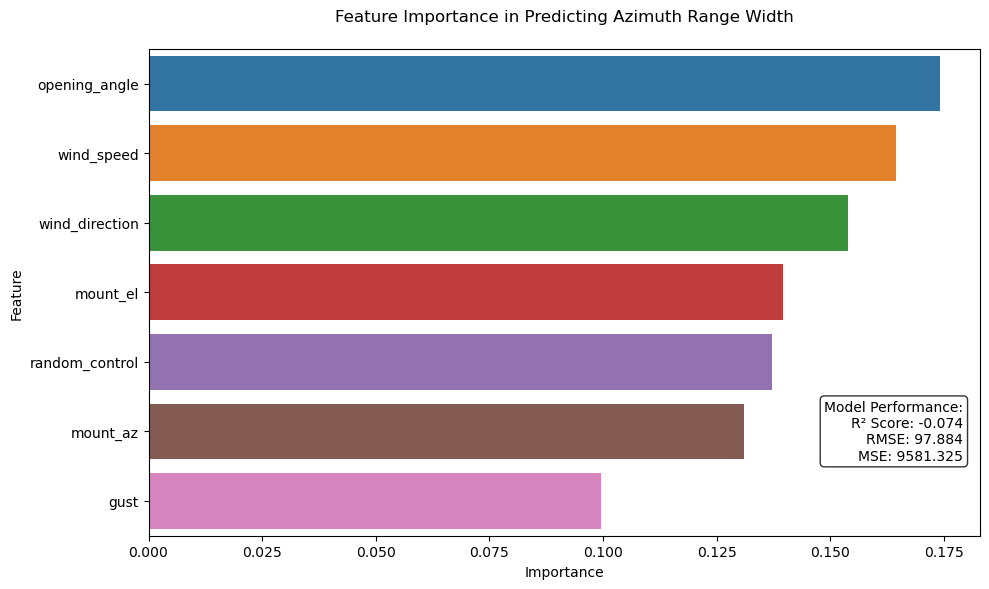


Feature Importance Rankings:
opening_angle: 0.1743
wind_speed: 0.1645
wind_direction: 0.1540
mount_el: 0.1396
random_control: 0.1372
mount_az: 0.1309
gust: 0.0995

Model Performance Metrics:
R² Score: -0.0741
Mean Squared Error: 9581.3252
Root Mean Squared Error: 97.8842


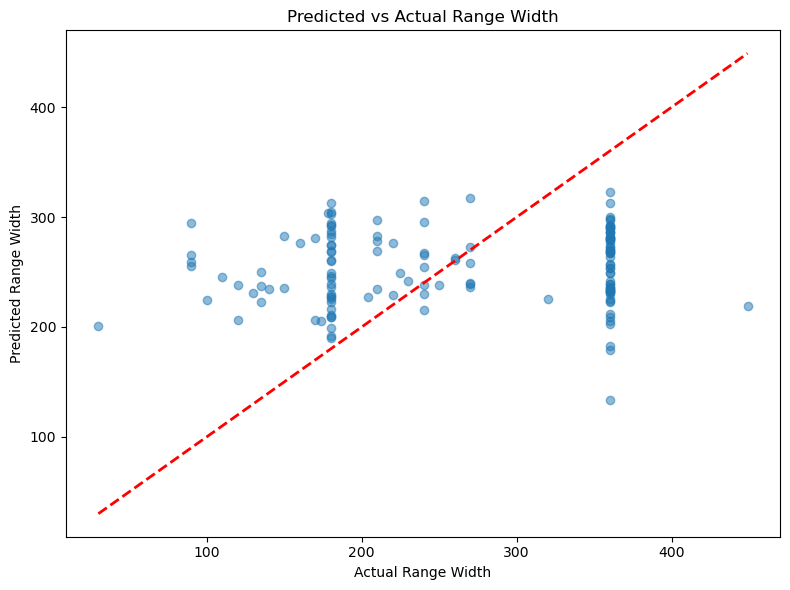

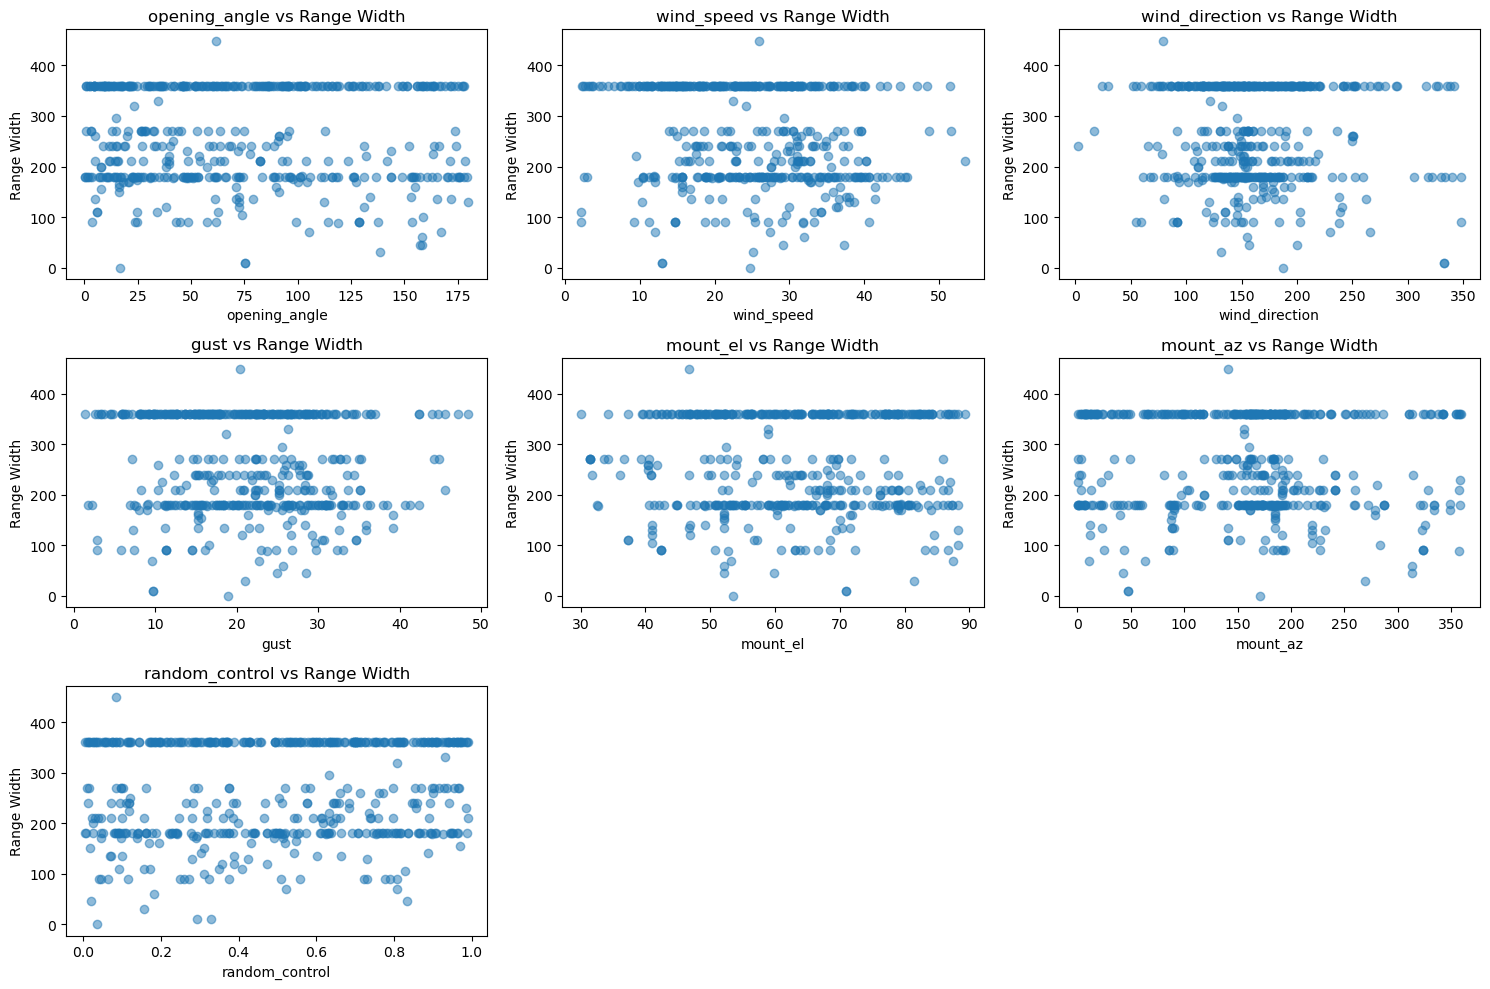


Feature Correlations with Range Width:
azrange_width     1.000000
random_control    0.112587
mount_el          0.003209
wind_direction   -0.035448
opening_angle    -0.035939
mount_az         -0.048630
gust             -0.105746
wind_speed       -0.186216
Name: azrange_width, dtype: float64

Example Predictions (first 10 test cases):
     Actual  Predicted  Difference
55    360.0     278.79       81.21
73    180.0     274.83       94.83
33    180.0     191.67       11.67
446   230.0     242.16       12.16
425   178.0     303.97      125.97
229   180.0     198.64       18.64
210   360.0     239.41      120.59
9     360.0     232.25      127.75
352   360.0     264.04       95.96
70    180.0     222.77       42.77


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Add random control variable
np.random.seed(42)
merged_df['random_control'] = np.random.random(size=len(merged_df))

# Prepare features and target
feature_cols = ['opening_angle', 'wind_speed', 'wind_direction', 'gust', 
                'mount_el', 'mount_az', 'random_control']
X = merged_df[feature_cols]
y = merged_df['azrange_width']  # Now predicting the actual range width

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train, y_train)

# Get feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Calculate performance metrics
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Create the feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in Predicting Azimuth Range Width', pad=20)
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add performance metrics text box
metrics_text = f'Model Performance:\nR² Score: {r2:.3f}\nRMSE: {rmse:.3f}\nMSE: {mse:.3f}'
plt.text(0.98, 0.15, metrics_text,
         transform=plt.gca().transAxes,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print the feature importance values and detailed metrics
print("\nFeature Importance Rankings:")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

print(f"\nModel Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Create scatter plots of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Range Width')
plt.ylabel('Predicted Range Width')
plt.title('Predicted vs Actual Range Width')
plt.tight_layout()
plt.show()

# Additional analysis of feature relationships
plt.figure(figsize=(15, 10))

# Plot relationships between features and range width
for i, feature in enumerate(feature_cols):
    plt.subplot(3, 3, i+1)
    plt.scatter(merged_df[feature], merged_df['azrange_width'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Range Width')
    plt.title(f'{feature} vs Range Width')
    
plt.tight_layout()
plt.show()

# Calculate feature correlations with range width
correlations = merged_df[feature_cols + ['azrange_width']].corr()['azrange_width'].sort_values(ascending=False)
print("\nFeature Correlations with Range Width:")
print(correlations)

# Print prediction examples
print("\nExample Predictions (first 10 test cases):")
example_df = pd.DataFrame({
    'Actual': y_test.iloc[:10],
    'Predicted': y_pred[:10],
    'Difference': np.abs(y_test.iloc[:10] - y_pred[:10])
})
print(example_df.round(2))

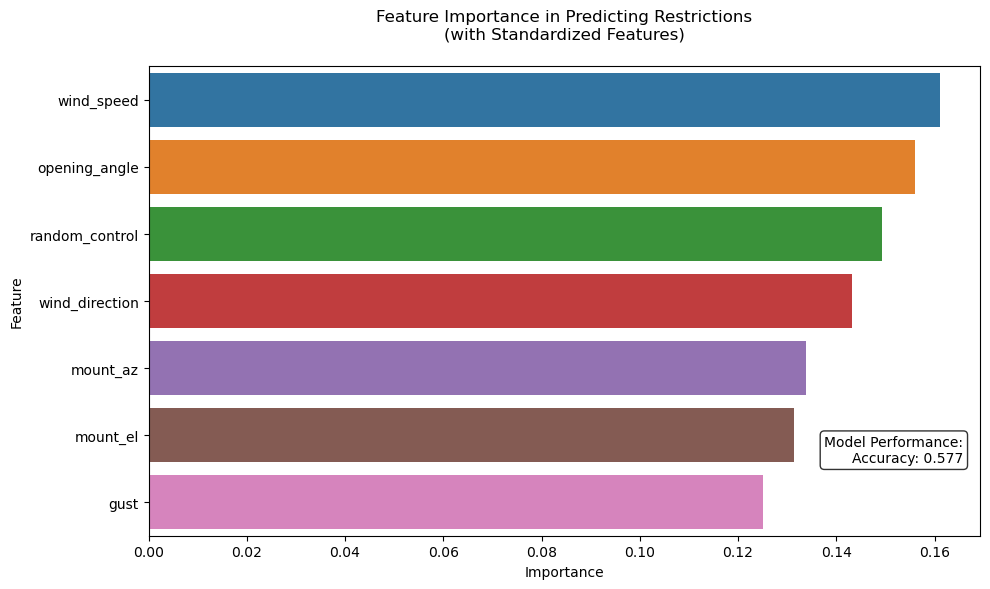


Feature Importance Rankings:
wind_speed: 0.1612
opening_angle: 0.1560
random_control: 0.1493
wind_direction: 0.1433
mount_az: 0.1339
mount_el: 0.1314
gust: 0.1250

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.44      0.47        62
           1       0.61      0.69      0.65        80

    accuracy                           0.58       142
   macro avg       0.57      0.56      0.56       142
weighted avg       0.57      0.58      0.57       142


Confusion Matrix:
[[27 35]
 [25 55]]


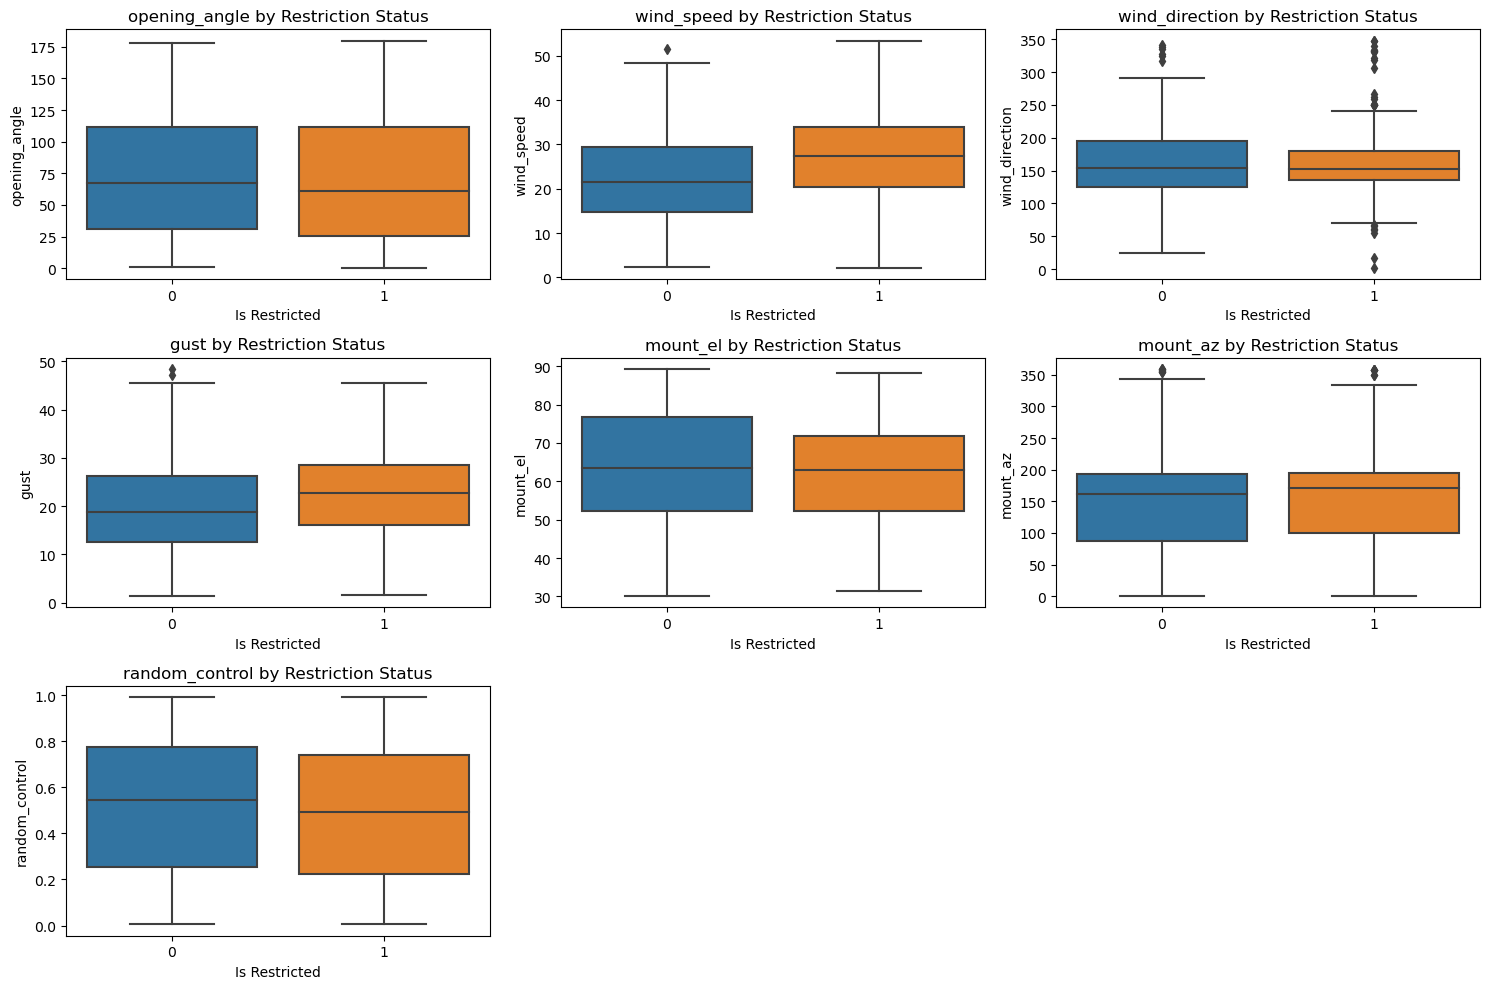


Mean values by restriction status:
               opening_angle  wind_speed  wind_direction    gust  mount_el  \
is_restricted                                                                
0                     75.013      22.071         161.943  19.700    63.719   
1                     71.457      27.066         160.731  22.679    62.530   

               mount_az  random_control  
is_restricted                            
0               152.183           0.518  
1               159.732           0.477  

Example Predictions (first 10 test cases):
     Actual  Predicted  Correct
55        0          1    False
73        1          1     True
33        1          1     True
446       1          0    False
425       1          0    False
229       1          1     True
210       0          1    False
9         0          1    False
352       0          1    False
70        1          1     True


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Add random control variable
np.random.seed(42)
merged_df['random_control'] = np.random.random(size=len(merged_df))

# Prepare features and target
feature_cols = ['opening_angle', 'wind_speed', 'wind_direction', 'gust', 
                'mount_el', 'mount_az', 'random_control']
X = merged_df[feature_cols]
y = merged_df['is_restricted']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train, y_train)

# Get feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Calculate performance metrics
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Create the feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in Predicting Restrictions\n(with Standardized Features)', pad=20)
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add performance metrics text box
metrics_text = f'Model Performance:\nAccuracy: {accuracy:.3f}'
plt.text(0.98, 0.15, metrics_text,
         transform=plt.gca().transAxes,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print the feature importance values and detailed metrics
print("\nFeature Importance Rankings:")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

print("\nDetailed Classification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

# Additional analysis of feature distributions by class
plt.figure(figsize=(15, 10))

# Plot distributions for each feature by restriction status
for i, feature in enumerate(feature_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=merged_df, x='is_restricted', y=feature)
    plt.title(f'{feature} by Restriction Status')
    plt.xlabel('Is Restricted')
    
plt.tight_layout()
plt.show()

# Calculate and print mean values for each feature by restriction status
print("\nMean values by restriction status:")
print(merged_df.groupby('is_restricted')[feature_cols].mean().round(3))

# Print example predictions
print("\nExample Predictions (first 10 test cases):")
example_df = pd.DataFrame({
    'Actual': y_test.iloc[:10],
    'Predicted': y_pred[:10],
    'Correct': y_test.iloc[:10] == y_pred[:10]
})
print(example_df)